In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.ensemble import StackingRegressor, VotingRegressor
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# from sklearn.preprocessing import StandardScaler
# import xgboost as xgb
# import lightgbm as lgb
# import pickle
# import os
# from datetime import timedelta

# # Load the dataset
# df = pd.read_csv("TransformedData.csv")
# df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
# print(f"Dataset shape: {df.shape}")
# df.head()

# # Feature engineering - temporal features
# df['year'] = df['Posted Time'].dt.year
# df['month'] = df['Posted Time'].dt.month
# df['day'] = df['Posted Time'].dt.day
# df['dayofweek'] = df['Posted Time'].dt.dayofweek
# df['quarter'] = df['Posted Time'].dt.quarter

# # Cyclical features
# df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
# df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
# df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
# df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# # Drop datetime column
# df.drop(columns=['Posted Time'], inplace=True)

# # Display information about the dataframe
# print(df.info())

# # Visualize correlation matrix
# plt.figure(figsize=(12, 10))
# sns.heatmap(df.corr(), cmap='coolwarm', cbar=True)
# plt.title("Correlation Matrix")
# plt.tight_layout()
# plt.show()

# # Top features correlated with target
# corr_with_price = df.corr()['Price per m2'].abs().sort_values(ascending=False).drop('Price per m2')
# print("Top 10 features correlated with Price per m2:\n", corr_with_price.head(10))

# # Split data
# y = df['Price per m2']
# X = df.drop('Price per m2', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=26
# )
# print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# # Load pre-trained models
# print("Loading pre-trained models...")
# try:
#     with open('xgboost_final_model.pmml', 'rb') as f:
#         xgb_model = pickle.load(f)
    
#     with open('lightgbm_final_model.pmml', 'rb') as f:
#         lgb_model = pickle.load(f)
        
#     print("Models loaded successfully!")
# except Exception as e:
#     print(f"Error loading models: {e}")
#     # Create basic models in case loading fails
#     print("Creating new base models...")
    
#     # Basic XGBoost
#     xgb_model = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=300,
#         learning_rate=0.05,
#         max_depth=5,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=26
#     )
    
#     # Basic LightGBM
#     lgb_model = lgb.LGBMRegressor(
#         objective='regression',
#         n_estimators=300,
#         learning_rate=0.05,
#         max_depth=5,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=26
#     )

# # Function to evaluate model
# def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
#     # Train predictions
#     y_train_pred = model.predict(X_train)
#     mse_train = mean_squared_error(y_train, y_train_pred)
#     rmse_train = np.sqrt(mse_train)
#     mae_train = mean_absolute_error(y_train, y_train_pred)
#     r2_train = r2_score(y_train, y_train_pred)
    
#     # Test predictions
#     y_test_pred = model.predict(X_test)
#     mse_test = mean_squared_error(y_test, y_test_pred)
#     rmse_test = np.sqrt(mse_test)
#     mae_test = mean_absolute_error(y_test, y_test_pred)
#     r2_test = r2_score(y_test, y_test_pred)
    
#     print(f"=== {model_name} Evaluation ===")
#     print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.5f}")
#     print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.5f}")
    
#     return {
#         'train_mse': mse_train, 'train_rmse': rmse_train, 
#         'train_mae': mae_train, 'train_r2': r2_train,
#         'test_mse': mse_test, 'test_rmse': rmse_test, 
#         'test_mae': mae_test, 'test_r2': r2_test,
#         'test_pred': y_test_pred
#     }

# # Ensure models are fit on the training data
# print("\nFitting base models...")
# xgb_model.fit(X_train, y_train)
# lgb_model.fit(X_train, y_train)

# # Evaluate individual models
# print("\nEvaluating individual models:")
# xgb_metrics = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, "XGBoost")
# lgb_metrics = evaluate_model(lgb_model, X_train, y_train, X_test, y_test, "LightGBM")

# # Create and train stacking ensemble
# print("\nBuilding stacking ensemble model...")

# # First, create out-of-fold predictions for meta-model training
# # This is critical to prevent information leakage that could cause poor generalization
# print("Generating out-of-fold predictions for meta-model training...")

# # Use the loaded models directly and generate OOF predictions
# kf = KFold(n_splits=5, shuffle=True, random_state=26)

# # Arrays to store out-of-fold predictions
# xgb_oof_preds = np.zeros(X_train.shape[0])
# lgb_oof_preds = np.zeros(X_train.shape[0])

# # Generate OOF predictions
# for train_idx, val_idx in kf.split(X_train):
#     # Split data
#     X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#     y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
#     # Train XGBoost
#     xgb_fold = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=300,
#         learning_rate=0.05,
#         max_depth=5,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=26
#     )
#     xgb_fold.fit(X_fold_train, y_fold_train)
#     xgb_oof_preds[val_idx] = xgb_fold.predict(X_fold_val)
    
#     # Train LightGBM
#     lgb_fold = lgb.LGBMRegressor(
#         objective='regression',
#         n_estimators=300,
#         learning_rate=0.05,
#         max_depth=5,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=26
#     )
#     lgb_fold.fit(X_fold_train, y_fold_train)
#     lgb_oof_preds[val_idx] = lgb_fold.predict(X_fold_val)

# # Create a meta-features dataset
# meta_features_train = np.column_stack([xgb_oof_preds, lgb_oof_preds])

# # Generate base model predictions on test set
# xgb_test_preds = xgb_model.predict(X_test)
# lgb_test_preds = lgb_model.predict(X_test)
# meta_features_test = np.column_stack([xgb_test_preds, lgb_test_preds])

# # Try different meta-models with hyperparameter tuning
# meta_models = {
#     'ridge': [Ridge(alpha=a) for a in [0.001, 0.01, 0.1, 0.5, 1.0, 5.0]],
#     'lasso': [Lasso(alpha=a) for a in [0.0001, 0.001, 0.01, 0.1]],
#     'elastic': [ElasticNet(alpha=a, l1_ratio=r) for a in [0.001, 0.01, 0.1] for r in [0.1, 0.5, 0.9]]
# }

# best_meta_model = None
# best_meta_params = None
# best_score = float('inf')

# # Train and evaluate different meta-models
# print("\nTesting different meta-models...")
# for name, models in meta_models.items():
#     for i, model in enumerate(models):
#         print(f"\nTesting {name} model with parameters: {model.get_params()}")
        
#         # Train meta-model
#         model.fit(meta_features_train, y_train)
        
#         # Make predictions
#         y_pred = model.predict(meta_features_test)
        
#         # Evaluate
#         mse = mean_squared_error(y_test, y_pred)
#         rmse = np.sqrt(mse)
#         mae = mean_absolute_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)
        
#         print(f"{name} #{i+1} - MSE: {mse:.5f}, RMSE: {rmse:.5f}, MAE: {mae:.5f}, R2: {r2:.5f}")
        
#         # Track the best model
#         if mse < best_score:
#             best_score = mse
#             best_meta_model = model
#             best_meta_params = {"type": name, "params": model.get_params()}
#             best_preds = y_pred

# print(f"\nBest meta-model: {best_meta_params}")

# # Create a final stacking model with the best meta-model
# # This time we will use proper feature scaling for the meta-model inputs
# scaler = StandardScaler()
# meta_features_train_scaled = scaler.fit_transform(meta_features_train)
# meta_features_test_scaled = scaler.transform(meta_features_test)

# # Train best meta-model on scaled data
# best_meta_model.fit(meta_features_train_scaled, y_train)
# best_preds_scaled = best_meta_model.predict(meta_features_test_scaled)

# # Evaluate the scaled meta-model
# mse = mean_squared_error(y_test, best_preds_scaled)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, best_preds_scaled)
# r2 = r2_score(y_test, best_preds_scaled)
# print(f"\nBest meta-model with scaling - MSE: {mse:.5f}, RMSE: {rmse:.5f}, MAE: {mae:.5f}, R2: {r2:.5f}")

# # Also try a simple weighted average approach (aka Voting)
# # Sometimes simpler ensembling methods can outperform stacking
# print("\nTrying weighted average ensemble...")
# for xgb_weight in [0.3, 0.4, 0.5, 0.6, 0.7]:
#     lgb_weight = 1 - xgb_weight
#     y_weighted_pred = xgb_weight * xgb_test_preds + lgb_weight * lgb_test_preds
    
#     mse = mean_squared_error(y_test, y_weighted_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test, y_weighted_pred)
#     r2 = r2_score(y_test, y_weighted_pred)
    
#     print(f"Weights (XGB: {xgb_weight:.1f}, LGB: {lgb_weight:.1f}) - MSE: {mse:.5f}, RMSE: {rmse:.5f}, R2: {r2:.5f}")
    
#     if mse < best_score:
#         best_score = mse
#         best_weighted_preds = y_weighted_pred
#         best_weights = (xgb_weight, lgb_weight)
#         weighted_metrics = {
#             'test_mse': mse, 
#             'test_rmse': rmse, 
#             'test_mae': mae, 
#             'test_r2': r2,
#             'test_pred': y_weighted_pred
#         }

# # Determine which approach is best
# if 'best_weighted_preds' in locals() and best_score == mean_squared_error(y_test, best_weighted_preds):
#     print(f"\nWeighted average is best with weights XGB: {best_weights[0]}, LGB: {best_weights[1]}")
#     best_ensemble_type = "weighted"
#     stack_metrics = weighted_metrics
    
#     # Create a simple custom model class for weighted predictions
#     class WeightedEnsemble:
#         def __init__(self, models, weights):
#             self.models = models
#             self.weights = weights
        
#         def predict(self, X):
#             preds = [model.predict(X) for model in self.models]
#             return sum(w * p for w, p in zip(self.weights, preds))
    
#     # Create the final model - FIX: Assign this to best_stack_model
#     best_stack_model = WeightedEnsemble(
#         models=[xgb_model, lgb_model],
#         weights=[best_weights[0], best_weights[1]]
#     )
# else:
#     print(f"\nMeta-model is best: {best_meta_params}")
#     best_ensemble_type = "meta"
    
#     # Create proper metrics dict for the scaled meta-model
#     stack_metrics = {
#         'test_mse': mean_squared_error(y_test, best_preds_scaled),
#         'test_rmse': np.sqrt(mean_squared_error(y_test, best_preds_scaled)),
#         'test_mae': mean_absolute_error(y_test, best_preds_scaled),
#         'test_r2': r2_score(y_test, best_preds_scaled),
#         'test_pred': best_preds_scaled
#     }
    
#     # Create a custom ensemble that combines model prediction and scaling
#     class ScaledMetaEnsemble:
#         def __init__(self, base_models, meta_model, scaler):
#             self.base_models = base_models
#             self.meta_model = meta_model
#             self.scaler = scaler
        
#         def predict(self, X):
#             # Get base model predictions
#             base_preds = [model.predict(X) for model in self.base_models]
#             meta_features = np.column_stack(base_preds)
            
#             # Scale features
#             meta_features_scaled = self.scaler.transform(meta_features)
            
#             # Get meta-model predictions
#             return self.meta_model.predict(meta_features_scaled)
    
#     # Create final model - FIX: Assign to best_stack_model
#     best_stack_model = ScaledMetaEnsemble(
#         base_models=[xgb_model, lgb_model],
#         meta_model=best_meta_model,
#         scaler=scaler
#     )

# # Final evaluation - Now best_stack_model is properly defined
# stack_metrics = evaluate_model(best_stack_model, X_train, y_train, X_test, y_test, "Final Stacking Model")

# # Visualize predictions vs actuals
# plt.figure(figsize=(10, 8))
# plt.scatter(y_test, stack_metrics['test_pred'], alpha=0.5, label='Stacking')
# plt.scatter(y_test, xgb_metrics['test_pred'], alpha=0.5, label='XGBoost')
# plt.scatter(y_test, lgb_metrics['test_pred'], alpha=0.5, label='LightGBM')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel("Actual Price")
# plt.ylabel("Predicted Price")
# plt.title("Actual vs. Predicted Prices")
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Visualize error distributions
# plt.figure(figsize=(12, 8))

# # Calculate errors
# stack_errors = y_test - stack_metrics['test_pred']
# xgb_errors = y_test - xgb_metrics['test_pred']
# lgb_errors = y_test - lgb_metrics['test_pred']

# plt.hist(stack_errors, bins=30, alpha=0.5, label='Stacking', edgecolor='k')
# plt.hist(xgb_errors, bins=30, alpha=0.5, label='XGBoost', edgecolor='k')
# plt.hist(lgb_errors, bins=30, alpha=0.5, label='LightGBM', edgecolor='k')
# plt.xlabel("Prediction Error")
# plt.ylabel("Frequency")
# plt.title("Error Distribution Comparison")
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Train the final model on the complete dataset
# print("\nTraining final ensemble model on full dataset...")

# # We need different approaches based on what worked best
# if best_ensemble_type == "weighted":
#     # For weighted approach, we need to train base models on full dataset
#     xgb_model.fit(X, y)
#     lgb_model.fit(X, y)
    
#     # Create a simple custom model class for weighted predictions
#     class WeightedEnsemble:
#         def __init__(self, models, weights):
#             self.models = models
#             self.weights = weights
        
#         def predict(self, X):
#             preds = [model.predict(X) for model in self.models]
#             return sum(w * p for w, p in zip(self.weights, preds))
    
#     # Create the final model
#     final_stack_model = WeightedEnsemble(
#         models=[xgb_model, lgb_model],
#         weights=[best_weights[0], best_weights[1]]
#     )
    
#     print(f"Created weighted ensemble with weights: XGB={best_weights[0]}, LGB={best_weights[1]}")
    
# else:  # best_ensemble_type == "meta"
#     # For meta-model approach, we need to:
#     # 1. Generate predictions from base models on full dataset
#     # 2. Train meta-model on these predictions
    
#     # Generate predictions from base models
#     xgb_full_preds = xgb_model.predict(X)
#     lgb_full_preds = lgb_model.predict(X)
#     meta_features_full = np.column_stack([xgb_full_preds, lgb_full_preds])
    
#     # Scale features
#     meta_features_full_scaled = scaler.fit_transform(meta_features_full)
    
#     # Create a fresh instance of the best meta-model
#     if best_meta_params["type"] == "ridge":
#         final_meta_model = Ridge(**best_meta_params["params"])
#     elif best_meta_params["type"] == "lasso":
#         final_meta_model = Lasso(**best_meta_params["params"])
#     else:  # elastic
#         final_meta_model = ElasticNet(**best_meta_params["params"])
    
#     # Train meta-model
#     final_meta_model.fit(meta_features_full_scaled, y)
    
#     # Create a custom ensemble that combines model prediction and scaling
#     class ScaledMetaEnsemble:
#         def __init__(self, base_models, meta_model, scaler):
#             self.base_models = base_models
#             self.meta_model = meta_model
#             self.scaler = scaler
        
#         def predict(self, X):
#             # Get base model predictions
#             base_preds = [model.predict(X) for model in self.base_models]
#             meta_features = np.column_stack(base_preds)
            
#             # Scale features
#             meta_features_scaled = self.scaler.transform(meta_features)
            
#             # Get meta-model predictions
#             return self.meta_model.predict(meta_features_scaled)
    
#     # Create final model
#     final_stack_model = ScaledMetaEnsemble(
#         base_models=[xgb_model, lgb_model],
#         meta_model=final_meta_model,
#         scaler=scaler
#     )
    
#     print(f"Created meta-model ensemble with {best_meta_params['type']} meta-model")

# # Save the final ensemble model
# print("Saving final ensemble model...")
# with open('ensemble_final_model.pmml', 'wb') as f:
#     pickle.dump(final_stack_model, f)

# # Save to resources directory for backend
# output_dir = '../../Backend/src/main/resources/'
# os.makedirs(output_dir, exist_ok=True)
# with open(output_dir + 'ensemble_final_model.pmml', 'wb') as f:
#     pickle.dump(final_stack_model, f)

# print("Saved final ensemble model to ensemble_final_model.pmml")

# # Function for forecasting
# def generate_forecast(model, X_base, days=90):
#     # Start date for forecast: today
#     start_date = pd.Timestamp.now().normalize()
    
#     # Take the last row as base features
#     base = X_base.iloc[-1].copy()
    
#     results = []
#     for i in range(days):
#         date = start_date + timedelta(days=i)
#         f = base.copy()
        
#         # Update time features
#         f['year'] = date.year
#         f['month'] = date.month
#         f['day'] = date.day
#         f['dayofweek'] = date.weekday()
#         f['quarter'] = date.quarter
        
#         # Update cyclical features
#         f['month_sin'] = np.sin(2 * np.pi * date.month / 12)
#         f['month_cos'] = np.cos(2 * np.pi * date.month / 12)
#         f['dayOfWeek_sin'] = np.sin(2 * np.pi * f['dayofweek'] / 7)
#         f['dayOfWeek_cos'] = np.cos(2 * np.pi * f['dayofweek'] / 7)
        
#         # Make prediction
#         X_pred = f.values.reshape(1, -1)
        
#         # Use appropriate prediction method based on model type
#         try:
#             pred_price = model.predict(X_pred)[0]
#         except:
#             # Handle other model types (like our custom ensemble)
#             pred_price = model.predict(X_pred)
#             # Ensure we have a scalar value
#             if isinstance(pred_price, np.ndarray):
#                 pred_price = pred_price[0]
        
#         results.append({
#             'Date': date,
#             'Predicted_Price_per_m2': pred_price
#         })
    
#     forecast_df = pd.DataFrame(results)
#     return forecast_df

# # Generate forecast with ensemble model
# print("\nGenerating 90-day forecast with ensemble model...")
# forecast_df = generate_forecast(final_stack_model, X)

# print("Forecast preview (first 5 days):")
# print(forecast_df.head())
# print("\nForecast preview (last 5 days):")
# print(forecast_df.tail())

# # Save forecast to CSV
# forecast_df.to_csv('price_forecast_ensemble.csv', index=False)
# print("Saved forecast to price_forecast_ensemble.csv")

# # Visualize forecast
# plt.figure(figsize=(12, 6))
# plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'])
# plt.title('90-Day Price per m² Forecast (Ensemble Model)')
# plt.xlabel('Date')
# plt.ylabel('Predicted Price per m²')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Compare forecasts from different models
# print("\nComparing forecasts from all models...")
# xgb_forecast = generate_forecast(xgb_model, X)
# lgb_forecast = generate_forecast(lgb_model, X)

# plt.figure(figsize=(12, 6))
# plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'], label='Ensemble')
# plt.plot(xgb_forecast['Date'], xgb_forecast['Predicted_Price_per_m2'], label='XGBoost')
# plt.plot(lgb_forecast['Date'], lgb_forecast['Predicted_Price_per_m2'], label='LightGBM')
# plt.title('Model Comparison: 90-Day Price per m² Forecast')
# plt.xlabel('Date')
# plt.ylabel('Predicted Price per m²')
# plt.grid(True)
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


In [2]:

# # Print conclusion
# print("\n=== Conclusion ===")
# print(f"XGBoost Test: MSE: {xgb_metrics['test_mse']:.5f}, RMSE: {xgb_metrics['test_rmse']:.5f}, R2: {xgb_metrics['test_r2']:.5f}")
# print(f"LightGBM Test: MSE: {lgb_metrics['test_mse']:.5f}, RMSE: {lgb_metrics['test_rmse']:.5f}, R2: {lgb_metrics['test_r2']:.5f}")
# print(f"Ensemble Test: MSE: {stack_metrics['test_mse']:.5f}, RMSE: {stack_metrics['test_rmse']:.5f}, R2: {stack_metrics['test_r2']:.5f}")

# # Calculate improvements
# xgb_improvement = (1 - stack_metrics['test_mse']/xgb_metrics['test_mse'])*100
# lgb_improvement = (1 - stack_metrics['test_mse']/lgb_metrics['test_mse'])*100

# print(f"\nImprovement over XGBoost: {xgb_improvement:.2f}%")
# print(f"Improvement over LightGBM: {lgb_improvement:.2f}%")

Dataset shape: (15539, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15539 entries, 0 to 15538
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Width                               15539 non-null  float64
 1   Length                              15539 non-null  float64
 2   Floors                              15539 non-null  float64
 3   Rooms                               15539 non-null  float64
 4   Toilets                             15539 non-null  float64
 5   Price per m2                        15539 non-null  float64
 6   1 Part Residential                  15539 non-null  int64  
 7   All Residential                     15539 non-null  int64  
 8   Back Expansion                      15539 non-null  int64  
 9   Car Alley                           15539 non-null  int64  
 10  Frontage                            15539 non-null  int64  
 11  No Residential

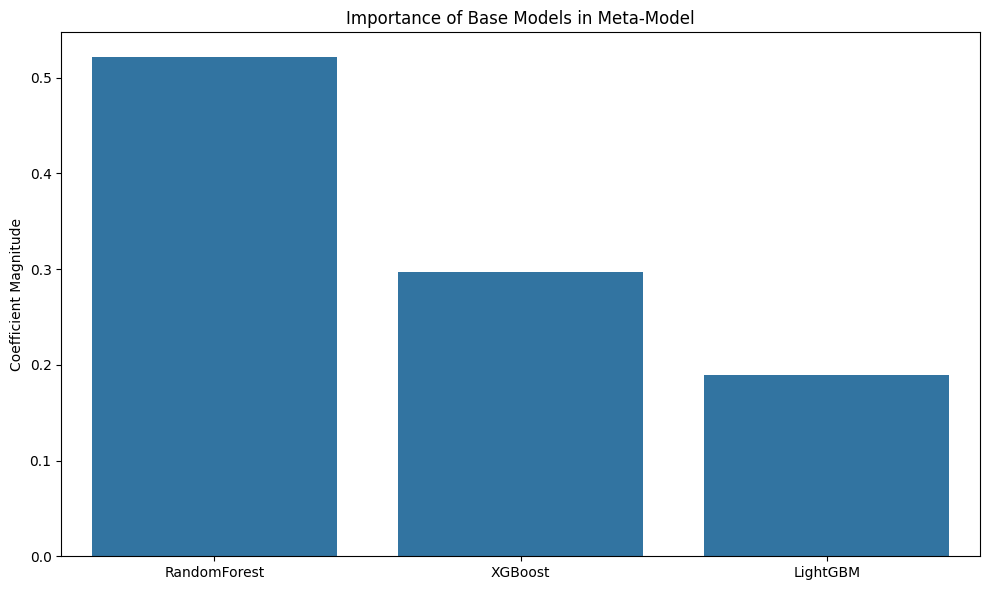

Improved Stacking Train scores: {'MSE': 0.05265, 'RMSE': 0.22946, 'MAE': 0.16498, 'R2': 0.81672}
Improved Stacking Test scores: {'MSE': 0.04845, 'RMSE': 0.22011, 'MAE': 0.15987, 'R2': 0.83281}


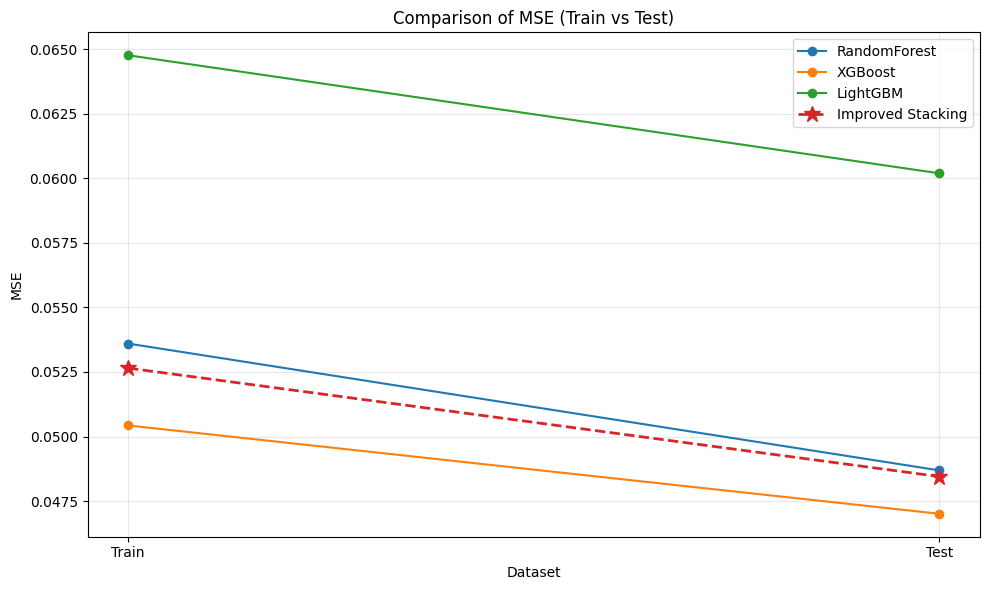

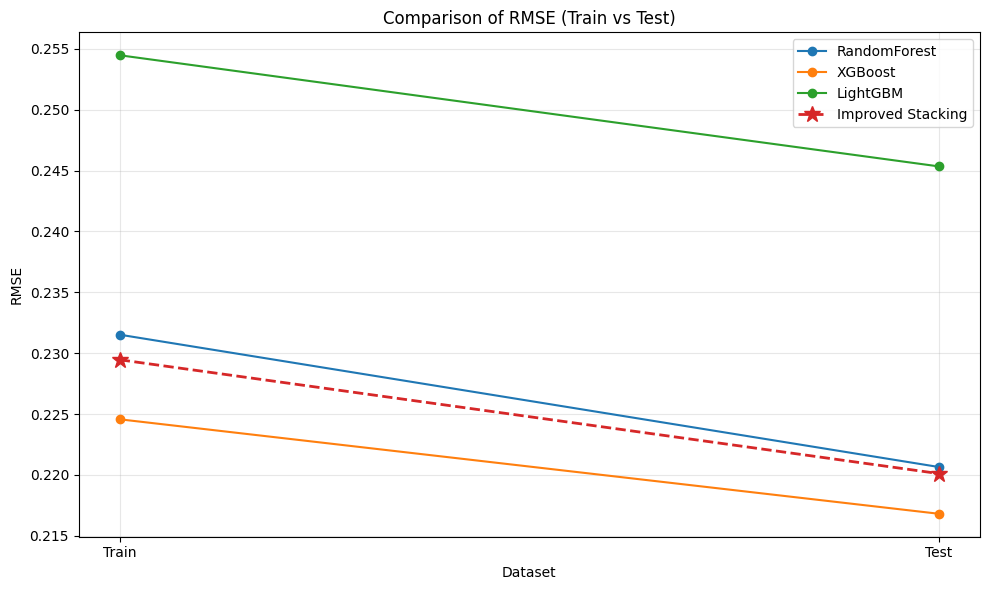

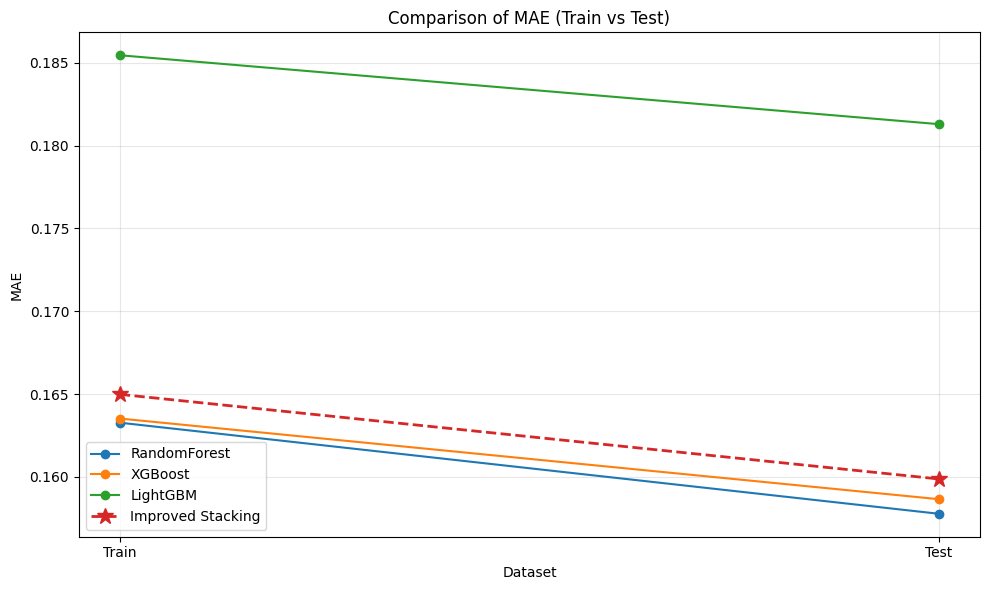

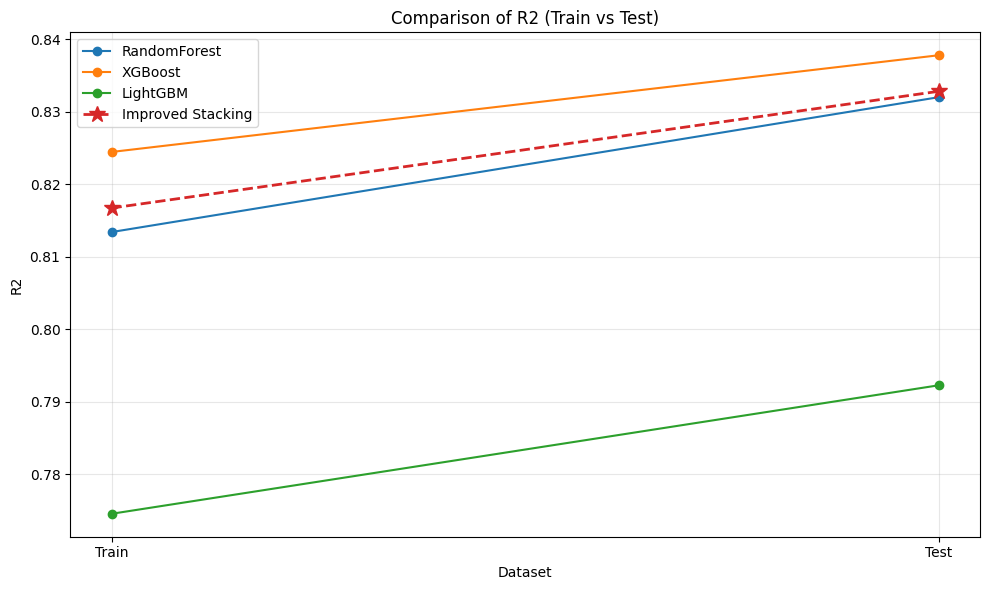

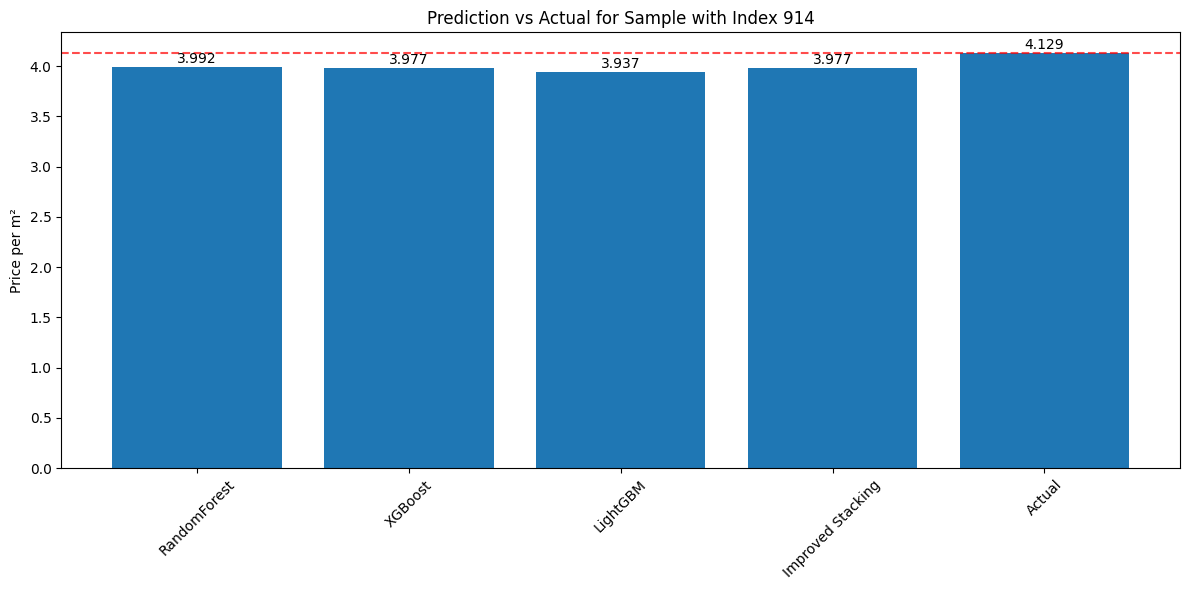


Absolute Error Comparison:
RandomForest: 0.13616
XGBoost: 0.15178
LightGBM: 0.19191
Improved Stacking: 0.15142

Stacking ensemble model has been saved to 'ensemble_final_model.pkl'
Prediction from function: 3.97717, actual: 4.12859


In [3]:
# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import KFold, train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Read data and preprocess time
# Change path if needed
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(f"Dataset shape: {df.shape}")

df['year'] = df['Posted Time'].dt.year
df['month'] = df['Posted Time'].dt.month
df['day'] = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter'] = df['Posted Time'].dt.quarter

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df.drop(columns=['Posted Time'], inplace=True)
print(df.info())

df.head()  # Output: First 5 rows

# Cell 3: Prepare data for stacking
target = 'Price per m2'
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train/Test shapes: {X_train.shape}/{X_test.shape}")

# Cell 4: Load models from Pickle
paths = {
    'RandomForest': 'random_forest_final_model.pkl',
    'XGBoost': 'xgboost_final_model.pkl',
    'LightGBM': 'lightgbm_final_model.pkl'
}
models = []
model_names = ['RandomForest', 'XGBoost', 'LightGBM']

for name, path in paths.items():
    with open(path, 'rb') as f:
        model = pickle.load(f)
    models.append(model)
    print(f"Loaded {name} model from {path}")

# Cell 5: Print hyperparameters of each model
for name, model in zip(model_names, models):
    print(f"{name} parameters: {model.get_params()}")

# Cell 6: Evaluate basic models on train and test
results = []
for i, (name, model) in enumerate(zip(model_names, models)):
    for split, (X_, y_) in zip(['Train', 'Test'], [(X_train, y_train), (X_test, y_test)]):
        preds = model.predict(X_)
        scores = {
            'Model': name,
            'Split': split,
            'MSE': round(mean_squared_error(y_, preds), 5),
            'RMSE': round(np.sqrt(mean_squared_error(y_, preds)), 5),
            'MAE': round(mean_absolute_error(y_, preds), 5),
            'R2': round(r2_score(y_, preds), 5)
        }
        results.append(scores)
        print(f"{name} {split} scores: {scores}")

df_results = pd.DataFrame(results)
df_results

# Cell 7: Improved Stacking - Create meta-features using cross-validation
print("\n--- Preparing Improved Stacking Ensemble ---")
# Number of folds for cross-validation
n_folds = 5
# Meta-model with regularization
meta_model = Ridge(alpha=0.5)

print(f"Creating meta-features using {n_folds}-fold cross-validation...")
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize meta-features array
meta_features_train = np.zeros((X_train.shape[0], len(models)))

# Create out-of-fold predictions for meta-features
for i, model in enumerate(models):
    # Use cross_val_predict to get OOF predictions
    meta_features_train[:, i] = cross_val_predict(model, X_train, y_train, cv=kfold, n_jobs=-1)
    print(f"Meta feature from {model_names[i]} completed")

# Cell 8: Train meta-model
print("Training meta-model...")
meta_model.fit(meta_features_train, y_train)

# Print meta-model parameters
print(f"Trained meta-model with coefficients: {meta_model.coef_.round(5)}")
print(f"Meta-model intercept: {meta_model.intercept_:.5f}")

# Get importance of each model in the meta-model
feature_importances = np.abs(meta_model.coef_)

# Cell 9: Plot importance of each base model
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=feature_importances)
plt.title('Importance of Base Models in Meta-Model')
plt.ylabel('Coefficient Magnitude')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Cell 10: Generate predictions from meta-model
# Function to create meta-features and predict
def predict_with_stacking(X, models, meta_model):
    """
    Predict using stacking model
    
    Parameters:
    -----------
    X : pd.DataFrame
        Input data for prediction
    models : list
        List of base models
    meta_model : object
        Meta-model for final prediction
    
    Returns:
    --------
    np.array: Predicted values
    """
    # Create meta-features from base models
    meta_features = np.column_stack([
        model.predict(X) for model in models
    ])
    
    # Predict with meta-model
    return meta_model.predict(meta_features)

# Create predictions for train and test sets
y_train_pred = predict_with_stacking(X_train, models, meta_model)
y_test_pred = predict_with_stacking(X_test, models, meta_model)

# Cell 11: Evaluate improved stacking
# Evaluate on train set
train_mse = round(mean_squared_error(y_train, y_train_pred), 5)
train_rmse = round(np.sqrt(train_mse), 5)
train_mae = round(mean_absolute_error(y_train, y_train_pred), 5)
train_r2 = round(r2_score(y_train, y_train_pred), 5)

# Evaluate on test set
test_mse = round(mean_squared_error(y_test, y_test_pred), 5)
test_rmse = round(np.sqrt(test_mse), 5)
test_mae = round(mean_absolute_error(y_test, y_test_pred), 5)
test_r2 = round(r2_score(y_test, y_test_pred), 5)

# Create results dictionary
stack_scores = {
    'Train': {'MSE': train_mse, 'RMSE': train_rmse, 'MAE': train_mae, 'R2': train_r2},
    'Test': {'MSE': test_mse, 'RMSE': test_rmse, 'MAE': test_mae, 'R2': test_r2}
}

print(f"Improved Stacking Train scores: {stack_scores['Train']}")
print(f"Improved Stacking Test scores: {stack_scores['Test']}")

# Cell 12: Plot metrics comparison
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    
    # Draw results from base models
    for model in df_results['Model'].unique():
        subset = df_results[df_results['Model'] == model]
        plt.plot(subset['Split'], subset[metric], marker='o', label=model)
    
    # Draw results from stacking
    plt.plot(['Train', 'Test'], 
             [stack_scores['Train'][metric], stack_scores['Test'][metric]],
             marker='*', linestyle='--', linewidth=2, markersize=12, label='Improved Stacking')
    
    plt.title(f'Comparison of {metric} (Train vs Test)')
    plt.xlabel('Dataset')
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Cell 13: Plot predictions for a random sample
# Choose a random index from test set
idx = X_test.sample(n=1, random_state=42).index[0]
X_single = X_test.loc[[idx]]
y_actual = y_test.loc[idx]

# Get predictions from models
preds_single = {name: model.predict(X_single)[0] for name, model in zip(model_names, models)}
preds_single['Improved Stacking'] = predict_with_stacking(X_single, models, meta_model)[0]
preds_single['Actual'] = y_actual

# Calculate errors
errors = {name: abs(pred - y_actual) for name, pred in preds_single.items() if name != 'Actual'}

# Plot predictions
plt.figure(figsize=(12, 6))
bars = plt.bar(preds_single.keys(), preds_single.values())

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', rotation=0)

plt.axhline(y=y_actual, color='r', linestyle='--', alpha=0.7)
plt.title(f'Prediction vs Actual for Sample with Index {idx}')
plt.ylabel('Price per m²')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print error comparison
print("\nAbsolute Error Comparison:")
for name, error in errors.items():
    print(f"{name}: {error:.5f}")

# Cell 14: Save the improved stacking model
# Create stacking object to save
stacking_model = {
    'models': models,
    'model_names': model_names,
    'meta_model': meta_model
}

with open('ensemble_final_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)
print("\nStacking ensemble model has been saved to 'ensemble_final_model.pkl'")

# Cell 15: Function to predict with saved model
def predict_with_saved_stacking(X, stacking_model):
    """
    Predict using saved stacking model
    
    Parameters:
    -----------
    X : pd.DataFrame
        Input data for prediction
    stacking_model : dict
        Dictionary containing stacking model components
    
    Returns:
    --------
    np.array: Predicted values
    """
    models = stacking_model['models']
    meta_model = stacking_model['meta_model']
    
    # Create meta-features from base models
    meta_features = np.column_stack([
        model.predict(X) for model in models
    ])
    
    # Predict with meta-model
    return meta_model.predict(meta_features)

# Test the function with a sample
sample_pred = predict_with_saved_stacking(X_single, stacking_model)
print(f"Prediction from function: {sample_pred[0]:.5f}, actual: {y_actual:.5f}")